In [2]:
from gerrychain import Graph

In [3]:
# Read Nebraska county graph from the json file "NE.county.json"
filepath = 'C:\\Users\\jayde\\Downloads\\'
filename = 'NE.county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [4]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    name = G.nodes[node]["NAME10"]
    population = G.nodes[node]['TOTPOP']
    x_coordinate = G.nodes[node]['C_X']
    y_coordinate = G.nodes[node]['C_Y']
    print("Node",node,"is",name,"County, which has population",population,"and is centered at (",x_coordinate,",",y_coordinate,")")

Node 0 is Burt County, which has population 6858 and is centered at ( -96.32860449772537 , 41.85156318148134 )
Node 1 is Dawson County, which has population 24326 and is centered at ( -99.81956570716875 , 40.86993611068622 )
Node 2 is Saunders County, which has population 20780 and is centered at ( -96.6374006543078 , 41.226370418187614 )
Node 3 is Thomas County, which has population 647 and is centered at ( -100.55585615683412 , 41.913506481234435 )
Node 4 is Antelope County, which has population 6685 and is centered at ( -98.06668529710544 , 42.17690346329143 )
Node 5 is Garfield County, which has population 2049 and is centered at ( -98.99138528755952 , 41.91435706851506 )
Node 6 is Sioux County, which has population 1311 and is centered at ( -103.7588786141739 , 42.487713959328204 )
Node 7 is Deuel County, which has population 1941 and is centered at ( -102.33394994226863 , 41.11159782186433 )
Node 8 is Pawnee County, which has population 2773 and is centered at ( -96.2370551788983

In [5]:
pip install geopy --user

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [5]:
from geopy.distance import geodesic

In [6]:
# create distance dictionary
dist = dict()
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'],  G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'],  G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [7]:
# check the dictionary by printing the Burt County -> Dawson County distance
print("Burt -> Dawson:",dist[0,15])

Burt -> Dawson: 100.36248360879618


In [8]:
# Let's impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 3          # number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 605737 and U = 611824 and k = 3


In [9]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create x[i,j] variable which equals one when county i 
#    is assigned to (the district centered at) county j
x = m.addVars(G.nodes, G.nodes, vtype=GRB.BINARY)

In [13]:
conda install gurobi

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [10]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create x[i,j] variable which equals one when county i 
#    is assigned to (the district centered at) county j
x = m.addVars(G.nodes, G.nodes, vtype=GRB.BINARY)

In [11]:
# objective is to minimize the moment of inertia: d^2 * p * x
m.setObjective( gp.quicksum( dist[i,j]*dist[i,j]*G.nodes[i]['TOTPOP']*x[i,j] for i in G.nodes for j in G.nodes), GRB.MINIMIZE )

In [12]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in G.nodes) == 1 for i in G.nodes)

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [13]:
# solve, making sure to set a 0.00% MIP gap tolerance(!)
m.Params.MIPGap = 0.0
m.optimize()

Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 8929 rows, 8649 columns and 43152 nonzeros
Model fingerprint: 0x2ba9d96a
Variable types: 0 continuous, 8649 integer (8649 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [3e+05, 8e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 188 rows and 4 columns
Presolve time: 0.11s
Presolved: 8741 rows, 8645 columns, 43142 nonzeros
Variable types: 0 continuous, 8645 integer (8645 binary)
Found heuristic solution: objective 2.096123e+10

Root relaxation: objective 8.483149e+09, 4458 iterations, 0.53 seconds

    Nodes    |    Current Node    |     Objective Bounds      

In [14]:
print("The moment of inertia objective is",m.objval)

# retrieve the districts and their populations
centers = [j for j in G.nodes if x[j,j].x > 0.5 ]
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in centers]
district_counties = [ [ G.nodes[i]["NAME10"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

The moment of inertia objective is 8540188553.811768
District 0 has population 609873 and contains counties ['Burt', 'Dakota', 'Cuming', 'Thurston', 'Stanton', 'Dodge', 'Douglas', 'Dixon']
District 1 has population 610651 and contains counties ['Saunders', 'Pawnee', 'Seward', 'Richardson', 'Saline', 'Jefferson', 'Otoe', 'Sarpy', 'Washington', 'Cass', 'Johnson', 'Nemaha', 'Gage', 'Lancaster']
District 2 has population 605817 and contains counties ['Dawson', 'Thomas', 'Antelope', 'Garfield', 'Sioux', 'Deuel', 'Boyd', 'Thayer', 'Hitchcock', 'Banner', 'Furnas', 'Clay', 'Merrick', 'Brown', 'Colfax', 'Arthur', 'Sheridan', 'Wayne', 'Garden', 'Keith', 'Pierce', 'Sherman', 'Dundy', 'Cheyenne', 'Box Butte', 'Wheeler', 'Lincoln', 'Hooker', 'Red Willow', 'Grant', 'Chase', 'Scotts Bluff', 'Greeley', 'Webster', 'Cherry', 'Boone', 'Dawes', 'Frontier', 'Nuckolls', 'Kearney', 'Howard', 'Keya Paha', 'Logan', 'Cedar', 'Loup', 'Polk', 'Blaine', 'Kimball', 'Gosper', 'Harlan', 'Phelps', 'Hamilton', 'Butler'

In [15]:
# Let's draw it on a map
import geopandas as gpd

In [21]:
# Read Nebraska county shapefile from "NE.counties.shp.shp"
filepath = 'C:\\Users\\jayde\\Downloads\\'
filename = 'NE_counties.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

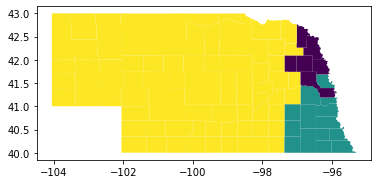

In [22]:
# Which district is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(districts)):
    
    # for each node i in this district
    for i in districts[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID10"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID10'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()